## Introduction

This notebook shows how to load and evaluate the MNIST and CIFAR-10 models synthesized and trained as described in the following paper:

M.Sinn, M.Wistuba, B.Buesser, M.-I.Nicolae, M.N.Tran: **Evolutionary Search for Adversarially Robust Neural Network** *ICLR SafeML Workshop 2019 (arXiv link to the paper will be added shortly)*.

The models were saved in `.h5` using Python 3.6, TensorFlow 1.11.0, Keras 2.2.4.

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist, cifar10
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import numpy as np

from art.config import ART_DATA_PATH
from art.classifiers import KerasClassifier
from art.attacks import ProjectedGradientDescent, DeepFool, PixelAttack, ThresholdAttack, NewtonFool, SaliencyMapMethod,FastGradientMethod
from art.utils import get_file

Using TensorFlow backend.


## MNIST

Three different MNIST models are available. Use the following URLs to access them:
- `mnist_ratio=0.h5`: trained on 100% benign samples (https://www.dropbox.com/s/bv1xwjaf1ov4u7y/mnist_ratio%3D0.h5?dl=1)
- `mnist_ratio=0.5.h5`: trained on 50% benign and 50% adversarial samples (https://www.dropbox.com/s/0skvoxjd6klvti3/mnist_ratio%3D0.5.h5?dl=1)
- `mnist_ratio=1.h5`: trained on 100% adversarial samples (https://www.dropbox.com/s/oa2kowq7kgaxh1o/mnist_ratio%3D1.h5?dl=1)

Load data:

## resnet50 + mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

path = './model/resnet50_mnist.h5'
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,1])

n = 10000
y_pred = classifier.predict(X_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))


attack = DeepFool(classifier, max_iter=40, batch_size = 64) 

n = 64
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

Accuracy on first 10000 benign test samples: 0.987700
Accuracy on first 64 adversarial test samples: 0.156250


[[3.6515384e-03 9.6442789e-01 8.0814410e-04 3.4017761e-03 3.8319704e-04
  2.2683407e-03 3.5691127e-04 1.6560791e-02 1.7357348e-03 6.4056977e-03]]


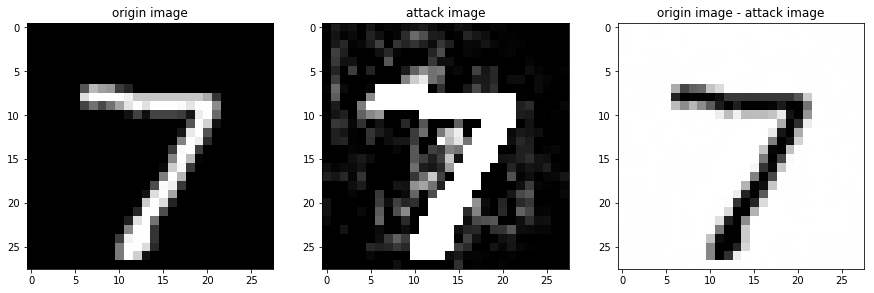

In [12]:
import matplotlib.pyplot as plt
choice = 0
image = X_test[choice].reshape(28,28)
image_adv = X_test_adv[choice].reshape(28,28)

fig, axs = plt.subplots(1,3, figsize = (15,10))

axs[0].imshow(image, cmap=plt.cm.gray)
axs[0].set_title("origin image")
axs[1].imshow(image_adv, cmap=plt.cm.gray)
axs[1].set_title("attack image")
axs[2].imshow(image_adv - image, cmap=plt.cm.gray)
axs[2].set_title("origin image - attack image")
print(classifier.predict(X_test_adv[choice:choice+1]))
plt.show()

## inceptionv3 + mnist

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

path = './model/inceptionv3_mnist.h5'
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,1])

n = 10000
y_pred = classifier.predict(X_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))


attack = SaliencyMapMethod(classifier, batch_size=64) 

n = 64*50
X_test_adv_2= attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv_2)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

Accuracy on first 10000 benign test samples: 0.994500
Accuracy on first 3200 adversarial test samples: 1.000000


In [27]:
print(y_pred[:10])
np.argmax(y_pred[:10], axis=1)

[[3.6124759e-03 9.6418077e-01 8.0161524e-04 3.3697805e-03 3.7973784e-04
  2.2528954e-03 3.4349147e-04 1.7037963e-02 1.6958660e-03 6.3255462e-03]
 [3.5243919e-03 9.6609467e-01 7.8276388e-04 3.3443740e-03 3.6816072e-04
  2.2298538e-03 3.6011275e-04 1.5546178e-02 1.7008227e-03 6.0486677e-03]
 [3.5199947e-03 9.6590394e-01 7.7835814e-04 3.3042291e-03 3.7226125e-04
  2.2126730e-03 3.5565230e-04 1.5822999e-02 1.6804456e-03 6.0494258e-03]
 [3.6399844e-03 9.6516842e-01 7.9757260e-04 3.3844393e-03 3.7867736e-04
  2.2622936e-03 3.6400344e-04 1.6040642e-02 1.7243185e-03 6.2397304e-03]
 [3.5866615e-03 9.6542770e-01 7.9919182e-04 3.3842898e-03 3.7675066e-04
  2.2453715e-03 3.6451119e-04 1.5906969e-02 1.7176839e-03 6.1908579e-03]
 [3.5306441e-03 9.6595240e-01 7.7837455e-04 3.3152737e-03 3.7099040e-04
  2.2122967e-03 3.5688363e-04 1.5716845e-02 1.6939148e-03 6.0724402e-03]
 [3.5840031e-03 9.6524954e-01 8.0569158e-04 3.3437354e-03 3.7872474e-04
  2.2564093e-03 3.6466122e-04 1.6222807e-02 1.7039875e-03 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

E.g. load the model trained on 50% benign and 50% adversarial samples:

In [6]:
path = 'inceptionv3_mnist.h5'
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,1])

Assess accuracy on first `n` benign test samples:

In [9]:
n = 10000
y_pred = classifier.predict(X_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))

Accuracy on first 10000 benign test samples: 0.994500


Define adversarial attack:

In [21]:
attack = DeepFool(classifier, max_iter=40, batch_size = 64) 

Assess accuracy on first `n` adversarial test samples:

In [23]:
n = 64*50
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

Accuracy on first 3200 adversarial test samples: 0.889062


In [15]:
y_test[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## CIFAR-10

Similarly to MNIST, three different CIFAR-10 models are available at the following URLs:
- `cifar-10_ratio=0.h5`: trained on 100% benign samples (https://www.dropbox.com/s/hbvua7ynhvara12/cifar-10_ratio%3D0.h5?dl=1)
- `cifar-10_ratio=0.5.h5`: trained on 50% benign and 50% adversarial samples (https://www.dropbox.com/s/96yv0r2gqzockmw/cifar-10_ratio%3D0.5.h5?dl=1)
- `cifar-10_ratio=1.h5`: trained on 100% adversarial samples (https://www.dropbox.com/s/7btc2sq7syf68at/cifar-10_ratio%3D1.h5?dl=1)

## resnet50 + cifar10

In [42]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image
x_train = x_train/128
x_test = x_test/128 
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

path = './model/resnet50_s_cifar10.h5'
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,255])

# n = 10000
# y_pred = classifier.predict(x_test[:n])
# accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
# print("Accuracy on first %i benign test samples: %f" % (n, accuracy))

attack = NewtonFool(classifier, max_iter=40, batch_size=64) 

n = 64*50
x_test_adv = attack.generate(x_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(x_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Accuracy on first 3200 adversarial test samples: 0.484375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
3


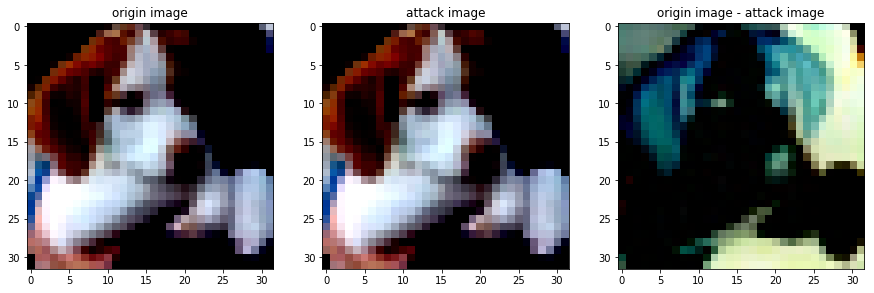

In [63]:
import matplotlib.pyplot as plt
choice = 16
image = x_test[choice].reshape(32,32,3)
image_adv = x_test_adv[choice].reshape(32,32,3)

fig, axs = plt.subplots(1,3, figsize = (15,10))

axs[0].imshow(image, cmap=plt.cm.gray)
axs[0].set_title("origin image")
axs[1].imshow(image_adv, cmap=plt.cm.gray)
axs[1].set_title("attack image")
axs[2].imshow(image_adv - image, cmap=plt.cm.gray)
axs[2].set_title("origin image - attack image")
print(np.argmax(classifier.predict(x_test[choice:choice+1])))
print(np.argmax(classifier.predict(x_test_adv[choice:choice+1])))

plt.show()

## inceptionv3 + cifar10

In [11]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32') 
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3).astype('float32') 
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

path = './model/inceptionv3_cifar10.h5'
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,255])

# n = 10000
# y_pred = classifier.predict(X_test[:n])
# accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
# print("Accuracy on first %i benign test samples: %f" % (n, accuracy))
attack = SaliencyMapMethod(classifier, batch_size=64) 

n = 64*50
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))


Accuracy on first 3200 adversarial test samples: 1.000000


In [ ]:
attack = NewtonFool(classifier, max_iter=40, batch_size=64) 

n = 64*40
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

Load data:

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3).astype('float32')
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170500096/170498071 [==============================] - 32s 0us/step


E.g. load the model trained on 50% benign and 50% adversarial samples:

In [8]:
path = get_file('cifar-10_ratio=0.5.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/96yv0r2gqzockmw/cifar-10_ratio%3D0.5.h5?dl=1')
model = load_model(path)
classifier = KerasClassifier(model=model, use_logits=False, clip_values=[0,255])

Assess accuracy on first `n` benign test samples:

In [9]:
n = 100
y_pred = classifier.predict(X_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))

Accuracy on first 100 benign test samples: 0.940000


Define adversarial attack:

In [10]:
attack = ProjectedGradientDescent(classifier, eps=8, eps_step=2, max_iter=10, targeted=False, 
                                  num_random_init=True) 

Assess accuracy on first `n` adversarial test samples:

In [11]:
n = 100
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

Accuracy on first 100 adversarial test samples: 0.450000
